# Christmas Tree Ornaments using RPRMakie.jl

- https://docs.makie.org/stable/explanations/backends/rprmakie.html#MaterialX-and-predefined-materials-materials.jl
- https://www.pexels.com/ja-jp/photo/3149896/

In [1]:
# import Pkg; Pkg.add("RadeonProRender")
# import Pkg; Pkg.add("GeometryBasics")
# import Pkg; Pkg.add("RPRMakie")
# import Pkg; Pkg.add("Colors")
# import Pkg; Pkg.add("FileIO")
# import Pkg; Pkg.add("MeshIO")
# import Pkg; Pkg.add("ImageIO")
# import Pkg; Pkg.add("ImageShow")

In [2]:
versioninfo()
import Pkg; Pkg.status("RPRMakie")

Julia Version 1.10.10
Commit 95f30e51f4 (2025-06-27 09:51 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: Windows (x86_64-w64-mingw32)
  CPU: 8 × 11th Gen Intel(R) Core(TM) i7-1185G7 @ 3.00GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-15.0.7 (ORCJIT, tigerlake)
Threads: 1 default, 0 interactive, 1 GC (on 8 virtual cores)
Status `C:\Users\user\.julia\environments\v1.10\Project.toml`
⌃ [22d9f318] RPRMakie v0.7.9
Info Packages marked with ⌃ have new versions available and may be upgradable.


In [3]:
using RadeonProRender
RadeonProRender.Context()

RadeonProRender.Context(Ptr{RadeonProRender.RPR.rpr_context_t} @0x000001619d5bf380, Base.IdSet{RadeonProRender.RPRObject}(IdDict{RadeonProRender.RPRObject, Nothing}()), Northstar)

[ Info: releasing old context


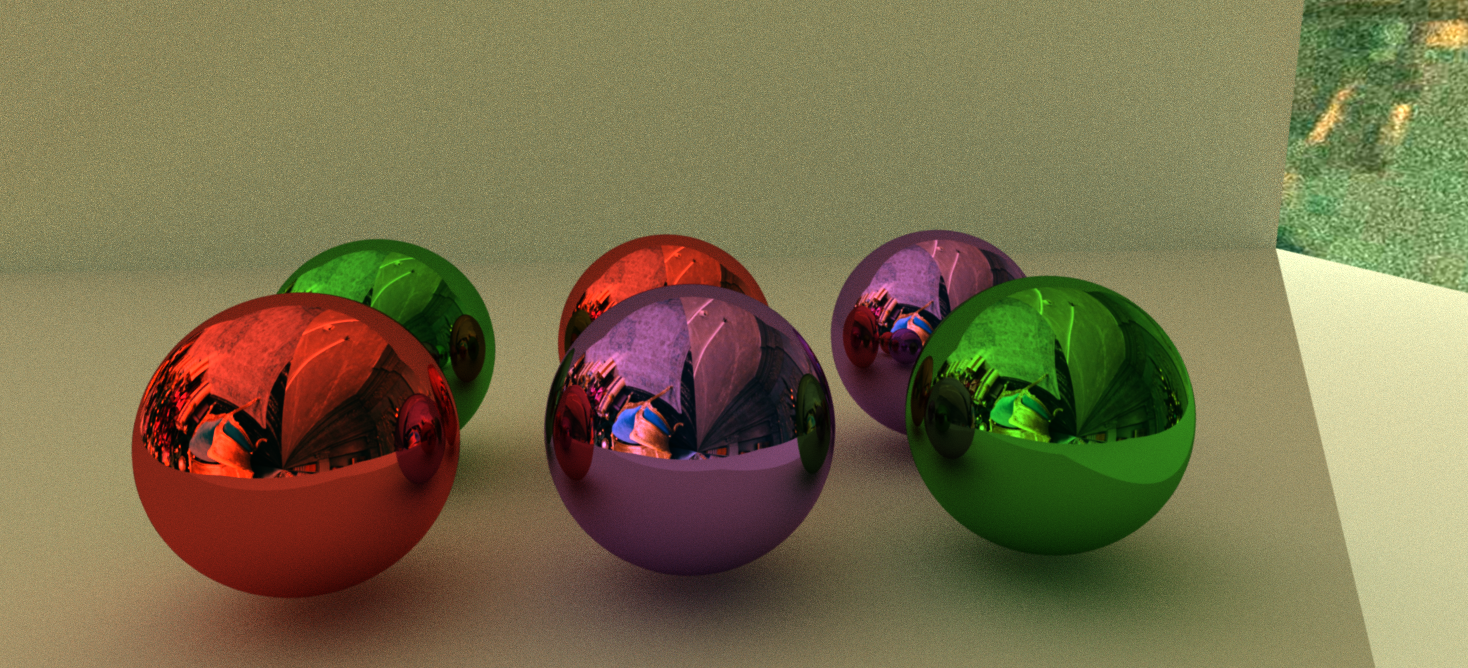

In [4]:
# パッケージ
using GeometryBasics
using RPRMakie
using FileIO
using Colors
using Colors: N0f8
using ImageShow

# CPUのみ使用
RPRMakie. activate!(
    plugin = RPR. Tahoe,
    resource = RPR.RPR_CREATION_FLAGS_ENABLE_CPU
)

# 背景
radiance = 500
lights = [
    EnvironmentLight(3.0, load("./pexels-cottonbro-3149896.jpg")),
    PointLight(Vec3f(10), RGBf(radiance, radiance * 1.1, radiance)),
]

# スクリーン
fig = Figure(; size=(1500, 700))
ax = LScene(fig[1, 1]; show_axis=false, scenekw=(; lights=lights))
screen = RPRMakie.Screen(ax.scene; 
    iterations = 100, # テスト時は5くらいでよい
    plugin = RPR. Tahoe, 
    resource = RPR.RPR_CREATION_FLAGS_ENABLE_CPU
)
matsys = screen.matsys

# 床を追加
floor_mat = RPR.DiffuseMaterial(matsys)
floor_mat.color = Vec4f(0.9, 0.9, 0.9, 1.0)
mesh!(ax, Rect3f(Vec3f(-5, -8, -0.5), Vec3f(10, 10, 0.1)); material=floor_mat, color=nothing)

# 壁を追加
wall_mat = RPR.DiffuseMaterial(matsys)
wall_mat.color = Vec4f(1.0, 1.0, 1.0, 1.0)
mesh!(ax, Rect3f(Vec3f(-5, 2, -0.5), Vec3f(10, 0.1, 5)); material=wall_mat, color=nothing)

# Juliaカラーを定義
julia_red = Vec4f(0.796, 0.235, 0.2, 1.0)      # #CB3C33
julia_green = Vec4f(0.22, 0.596, 0.149, 1.0)   # #389826
julia_purple = Vec4f(0.584, 0.345, 0.698, 1.0) # #9558B2

# Juliaカラーのマテリアルを作成
red_mat = RPR. Chrome(matsys)
red_mat.color = julia_red

green_mat = RPR.Chrome(matsys)
green_mat.color = julia_green

purple_mat = RPR.Chrome(matsys)
purple_mat.color = julia_purple

# マテリアル配列
materials = [
    red_mat green_mat
    purple_mat red_mat
    green_mat purple_mat
]

# 球体をグリッドに配置
for i in CartesianIndices(materials)
    x, y = Tuple(i)
    mat = materials[i]
    
    # 位置計算
    v = Vec3f(((x, y) .- (0.5 .* size(materials)) .- 0.5)..., 0)
    pos = 0.9 .* (v .- Vec3f(0, 3, 0))
    
    # 球体を作成して配置
    sphere_mesh = uv_mesh(Tesselation(Sphere(Point3f(pos...), 0.35f0), 64))
    mesh!(ax, sphere_mesh; material=mat, color=nothing)
end

# カメラ設定
cam = cameracontrols(ax.scene)
cam.eyeposition[] = Vec3f(-0.2, -5.6, 0.8)
cam.lookat[] = Vec3f(0.5, 0, -0.5)
cam.upvector[] = Vec3f(0, 0, 1)
cam.fov[] = 35

image = colorbuffer(screen)
save("ChristmasTreeOrnaments.png", image)
image